# Project Introduction

__[Department of Transportation's Responsibilities](https://www.google.com/search?client=safari&rls=en&q=department+of+transportation+responsibilities&ie=UTF-8&oe=UTF-8)__

Through this dataset, I have identified the three following patterns:
1. IDEA 1 w/ LOCAL LINK
2. IDEA 2 w/ LOCAL LINK
3. IDEA 3 w/ LOCAL LINK

## Resources:

- __[Kaggle-Full](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents/data)__

- __[Kaggle-Sampled](https://drive.google.com/file/d/1U3u8QYzLjnEaSurtZfSAS_oh9AT2Mn8X/edit)__

- __[Bing API](https://learn.microsoft.com/en-us/bingmaps/rest-services/traffic/get-traffic-incidents#supported-http-methods)__

- __[MQuest API](https://developer.mapquest.com/documentation/api/traffic/incidents/get.html)__

- __['A Countrywide Traffic Accident Dataset'](https://arxiv.org/pdf/1906.05409)__

- __['Accident Risk Prediction based on Heterogenous Sparse Data: New Dataset & Insights](https://arxiv.org/pdf/1909.09638)__

# 1-Setup Environment

## Libraries

In [1]:
#Utilities
import warnings

# Data Basics
import pandas as pd
import numpy as np
import missingno as msgno

#Time Data
from datetime import date, timedelta


#PySpark
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics
import pyspark.sql.functions as F

#Visuals
import matplotlib.pyplot as plt
import seaborn as sns


# Statistical Analysis
from scipy.stats import zscore, f_oneway, chi2_contingency, chisquare
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Spatial Tools
import geopy
import geopy.distance

# Text Tools
import re
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams

In [2]:
#api = geopy.Nominatim(user_agent='Capstone_Project_1')
#(a,b) = data[data['Street'].str.startswith('I-',na=False)].iloc[0][['Start_Lat','Start_Lng']]
#lat_long = f'{a},{b}'
#local = api.reverse(lat_long)
#local.address

## Info on New Libraries
For improved analysis, these libraries were included, but not covered in the material:

- __[Geopy:  ](https://geopy.readthedocs.io/en/stable/)__

- MissingNo:  
    * __[Library](https://github.com/ResidentMario/missingno)__
    
    * __[Tutorial](https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/)__

## Settings

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)
_LITE_SWITCH_ = True
_SPARK_ = False

## Custom Functions

In [4]:
# For High-level data exploration
def count_outliers(df_col,cap=3):
    zs = zscore(df_col)
    return df_col[zs > cap].shape[0]

In [5]:
# For Identify Unusual Weather Pattern(s)
def unusual_weather(observation):
    flag = False
    return flag

In [6]:
def dist(pt_0,pt_1):
    return geopy.distance.distance(pt_0,pt_1).miles

In [7]:
def highway_indicator(eventA):
    pass

In [8]:
def same_road(eventA,eventB):
    indicator = False
    road_identifiers = ['Street','City','State','Zipcode']
    indicator = all(eventA[id]==eventB[id] for id in road_identifiers)
    return indicator

In [9]:
# For indicating whether two events are close in space and, optionally, time.
def proximity_indicator(eventA,eventB,space_band=15,time_band=0):
    flag = False
    distance = dist(eventA[['longitude','latitude']],eventB[['longitude','latitude']])
    if (time_band > 0):
        time_lapse = abs(eventA['time']-eventB['time'])
        flag = bool((space_band > distance) and (time_band > time_lapse))
    else:
        flag = bool(space_band > distance)
    return flag

In [10]:
def test_category(feature_name):
    # Time of Impact--ANOVA
    model_time = ols(f"Q('Time_of_Impact(hr)') ~ C({feature_name})", data=data_clean).fit()
    anova_table_time = sm.stats.anova_lm(model_weather, typ=2)
    # Distance of Impact--ANOVA
    model_distance = ols(f"Q('Distance(mi)') ~ C({feature_name})", data=data_clean).fit()
    anova_table_distance = sm.stats.anova_lm(model_weather, typ=2)
    # Severity Distribution--ANOVA
    contingency_table = pd.crosstab(data_clean['Weather_Condition'], data_clean['Severity'])
    chi_results = chi2_contingency(contingency_table)
    return anova_table_time, anova_table_distance, chi_results

In [11]:
# Holiday Indicators
# Given by Google:
def calculate_memorial_day(year):
    # Get the last day of May
    last_day_of_may = date(year, 5, 31)

    # Get the weekday of the last day of May (0=Monday, 6=Sunday)
    weekday = last_day_of_may.weekday()

    # Calculate the offset to get to the last Monday
    offset = (weekday - 0) % 7

    # Calculate Memorial Day
    memorial_day = last_day_of_may - timedelta(days=offset)

    return memorial_day

# Given by Google:
def get_thanksgiving_date(year):
    # Get the first day of November
    first_november = date(year, 11, 1)
    
    # Calculate the day of the week for the first of November (0 = Monday, 6 = Sunday)
    first_day_weekday = first_november.weekday()
    
    # Calculate the number of days to add to get to the first Thursday
    days_to_first_thursday = (3 - first_day_weekday) % 7
    
    # Calculate the date of the first Thursday of November
    first_thursday = first_november + timedelta(days=days_to_first_thursday)
    
    # Add 3 weeks (21 days) to get to the fourth Thursday (Thanksgiving)
    thanksgiving_date = first_thursday + timedelta(days=21)
    
    return thanksgiving_date

def get_labor_day(year):
    first = date(year,9,1)
    d = first
    while d.weekday() > 0:
       d = d + timedelta(days=1)
    return d

## Load Dataset

In [12]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('US_Accidents_March23.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('US_Accidents_March23_sampled_500k.csv')
    else:
        data = pd.read_csv('US_Accidents_March23.csv')
    

# 2-Initial EDA

## Schema & Feature Basics

In [13]:
if _SPARK_:
    data.printSchema()
    print("Features: ",len(data.columns))
    print("Entries:  ",data.count())
else:
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                279623 non-null  float64
 8   End_Lng                279623 non-null  float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            499999 non-null  object 
 11  Street                 499309 non-null  object 
 12  City                   499981 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu

In [14]:
if _SPARK_:
    data.show(5,vertical=False)
else:
    data.head(5)

In [15]:
if _SPARK_:
    data.describe().show()
else:
    pass
    

Very large dataset with over 7.7 million observations.  (I also chose to do some initial analysis ont he kaggle-provided sampled dataset which contains only 500k observations.)  So we will have to handle with care either by using Spark or through other tricks.


Notes on Features: Dimensionally much more managable with just 45 features.
- 'Severity' would appear to be the primary variable of interest; 'Description' might be interesting to experiment with.
    * Upon further research, there is a 'Distance(mi)' feature that reflects the mileage of road that was impacted.
    * Furthermore, we can calculate the duration of impact by calculating the delta between 'Start_Time' & 'End_Time'

- 'Description' feature might be an interesting avenue to explore.  However, I suspect that it is collected/generated after the fact so there wouldn't be much predictive value.

- A number of location features
    * 'Start_Lat'/'Start_Lng' are easy enough to interpret but not sure what is meant by 'End_Lat' and 'End_Lng'
    * Similar question for 'Distance(mi)'
    * Street and City might not be useful features since they are not informative without further context.  

- Identifiers in ID and Source

- We have three time features ('Weather_Timestamp', 'Start_Time' and 'End_Time').
    * They need to be [converted to datetimes](#datetimes).  Right now they are just strings.
    * There may be an issue with inconsistent formatting.
    * It may be interesting to use these values to engineer some features like time of day, season, weekday/weekend, etc.
    * However, the information contained in 'Weather_Timestamp' is unclear.

- There are 9 (not including 'Weather_Timestamp') features on the weather.
    * Visability is probably the most relevant of these but 'Weather_Condition' might be a fine substitute/summary.

-There are 5 binary features indicating whether or not it was light or dark out at the time of the incident.

- Next are 10 binary features which seem to provide some information about the road infrastructure at the location of the accident.  


In [16]:
_TARGET_ = ['Severity']
_NUMERICS_ = ['Distance(mi)','Temperature(F)',
              'Wind_Chill(F)','Humidity(%)','Pressure(in)',
              'Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']

## Missing Values

In [17]:
if _SPARK_:
    missing = data.select(*[F.sum(F.isnull(F.col(c)).cast("int")).alias(c) for c in data.columns])
    print(missing.show(vertical=True))
else:
    print(data.isna().sum().sort_values(ascending=False))

End_Lat                  220377
End_Lng                  220377
Precipitation(in)        142616
Wind_Chill(F)            129017
Wind_Speed(mph)           36987
Visibility(mi)            11291
Wind_Direction            11197
Humidity(%)               11130
Weather_Condition         11101
Temperature(F)            10466
Pressure(in)               8928
Weather_Timestamp          7674
Nautical_Twilight          1483
Civil_Twilight             1483
Sunrise_Sunset             1483
Astronomical_Twilight      1483
Airport_Code               1446
Street                      691
Timezone                    507
Zipcode                     116
City                         19
Description                   1
Traffic_Signal                0
Roundabout                    0
Station                       0
Stop                          0
Traffic_Calming               0
Country                       0
Turning_Loop                  0
No_Exit                       0
End_Time                      0
Start_Ti

There is a lot of missing data. 

- Most notably, the 'End_Lat'/'End_Lng'.  Will have to confirm but it would appear that observations missing one are also missing the other.  
- There aren't any missing values for 'Severity' as well as basic location data (gps + state/county).
- Only a handful of observations are missing 'Description' which may prove convenient.


<Axes: >

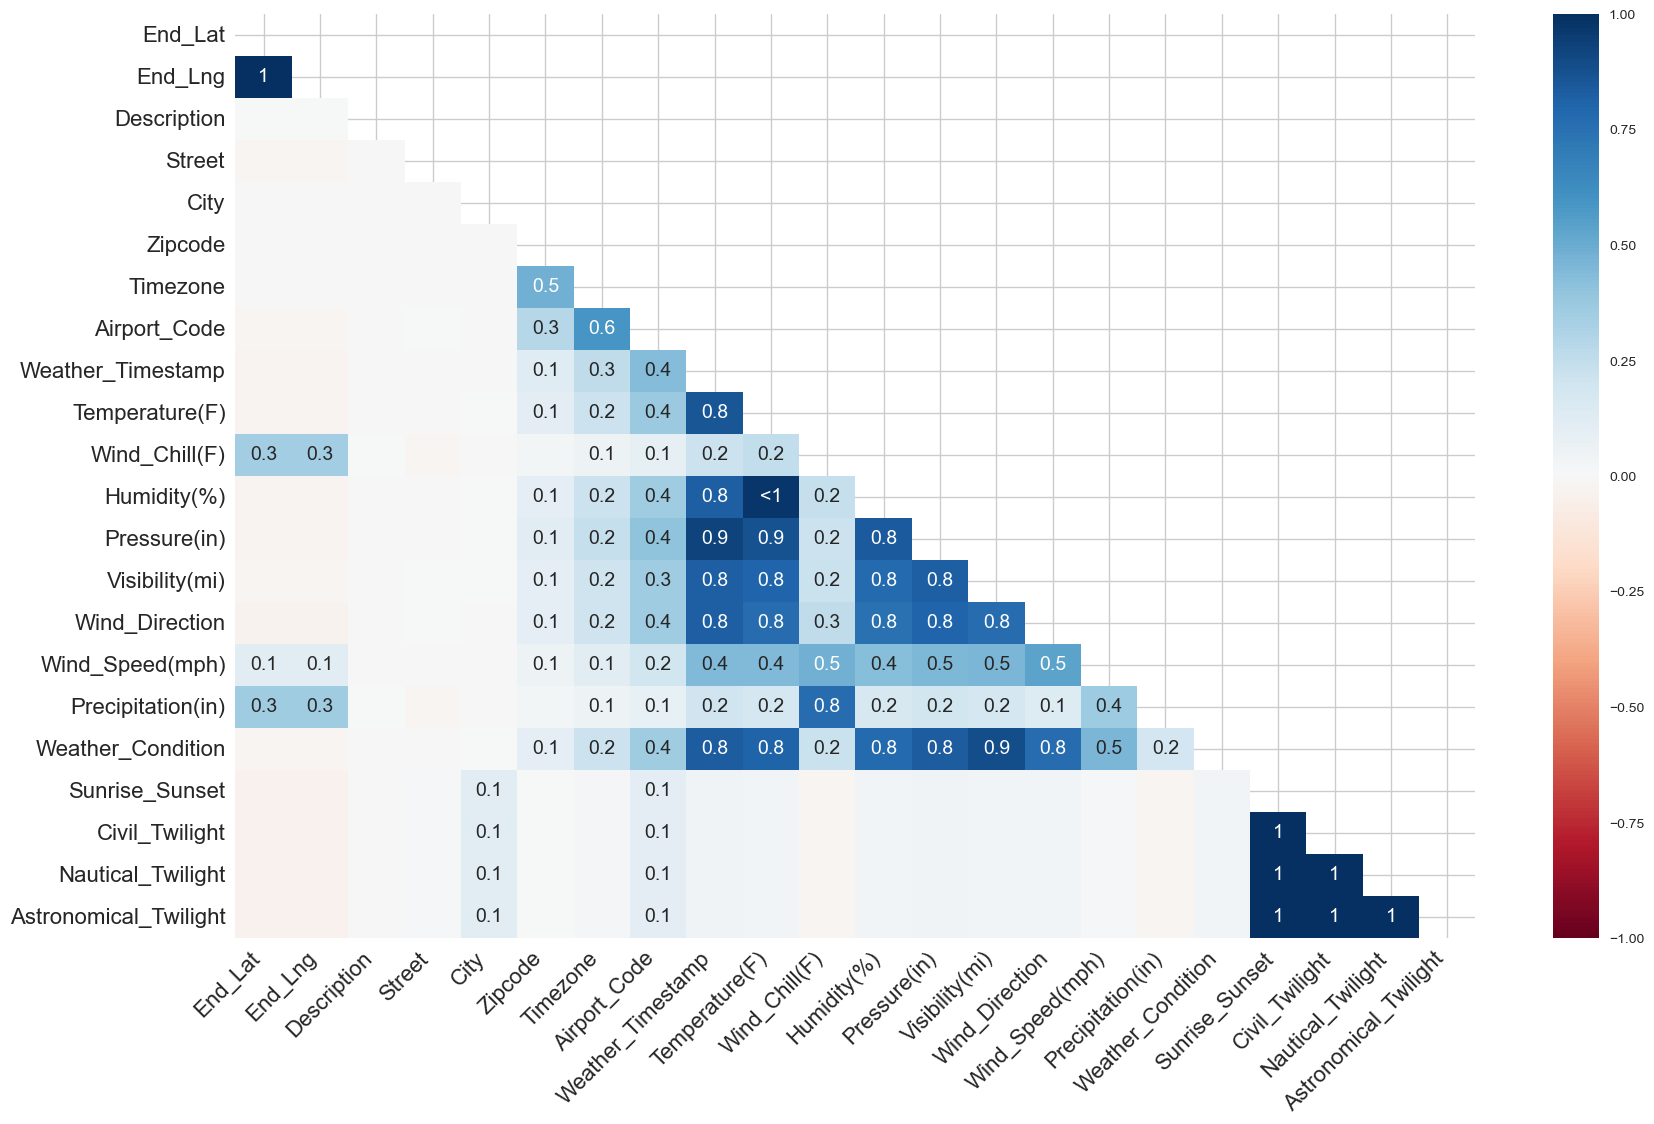

In [18]:
msgno.heatmap(data)

Good to know:
* Confirmed that Latitude/Longitude Data are strictly missing together.

* Weather data seems to be missing together in general but not perfectly missing and not a uniform relationship (Precipitation and Wind Direction for example).

* The day/night variables are strictly missing together.  

## Duplicates

There are no duplicates to deal with:

In [19]:
if _SPARK_:
    duplicates = int(data.count() - data.dropDuplicates().count())
    duplicates.show()
else:
    print(data.duplicated().sum())

0


## Outliers

In [20]:
if _SPARK_:
    pass
else:
    print(pd.DataFrame({c:{z:count_outliers(data[c],z) for z in [3,5,10,15,20]} for c in _NUMERICS_}).T)

                     3     5    10   15   20
Distance(mi)       7079  2660  632  248  114
Temperature(F)        0     0    0    0    0
Wind_Chill(F)         0     0    0    0    0
Humidity(%)           0     0    0    0    0
Pressure(in)          0     0    0    0    0
Visibility(mi)        0     0    0    0    0
Wind_Speed(mph)       0     0    0    0    0
Precipitation(in)     0     0    0    0    0


The distance feature may have some outlier issues.  However, this may be a function of the feature's nature as almost all incidents will not impact a large swath of the road. 

## High-Level Features

### Nature of Accident

In [21]:
data['Severity'].value_counts()

Severity
2    398142
3     84520
4     13064
1      4274
Name: count, dtype: int64

In [22]:
data['Distance(mi)'].value_counts(bins=25).sort_index(ascending=True)

(-0.194, 7.739]       495934
(7.739, 15.478]         3145
(15.478, 23.218]         549
(23.218, 30.957]         194
(30.957, 38.696]          83
(38.696, 46.435]          38
(46.435, 54.174]          18
(54.174, 61.914]          13
(61.914, 69.653]           8
(69.653, 77.392]           8
(77.392, 85.131]           2
(85.131, 92.87]            1
(92.87, 100.61]            1
(100.61, 108.349]          1
(108.349, 116.088]         1
(116.088, 123.827]         0
(123.827, 131.566]         1
(131.566, 139.306]         0
(139.306, 147.045]         0
(147.045, 154.784]         2
(154.784, 162.523]         0
(162.523, 170.262]         0
(170.262, 178.002]         0
(178.002, 185.741]         0
(185.741, 193.48]          1
Name: count, dtype: int64

In [23]:
(data['Distance(mi)']==0).sum()/data.shape[0]

0.427174

In [24]:
data[data['Distance(mi)']==0].groupby('Severity').count()

,ID,Source,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
Severity,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3996,3996,3996,3996,3996,3996,1604,1604,3996,3996,3993,3996,3996,3996,3993,3996,3988,3984,3952,3912,3847,3905,3939,3933,3907,3898,3749,3934,3996,3996,3996,3996,3996,3996,3996,3996,3996,3996,3996,3996,3996,3983,3983,3983,3983
2,147901,147901,147901,147901,147901,147901,21160,21160,147901,147901,147862,147898,147901,147901,147883,147901,147715,147637,146104,145391,94482,145220,145824,145238,145259,134156,89328,145201,147901,147901,147901,147901,147901,147901,147901,147901,147901,147901,147901,147901,147901,147851,147851,147851,147851
3,61118,61118,61118,61118,61118,61118,2675,2675,61118,61117,61076,61117,61118,61118,61103,61118,61083,60972,60307,59940,35755,59868,60107,59780,60002,54559,34210,59795,61118,61118,61118,61118,61118,61118,61118,61118,61118,61118,61118,61118,61118,61087,61087,61087,61087
4,572,572,572,572,572,572,422,422,572,572,572,572,572,572,571,572,571,570,567,565,437,565,564,562,557,527,425,559,572,572,572,572,572,572,572,572,572,572,572,572,572,572,572,572,572


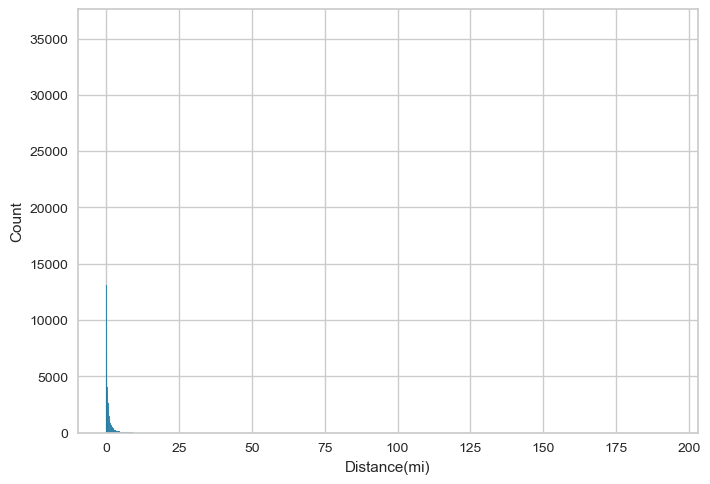

In [25]:
sns.histplot(data[data['Distance(mi)'] > 0]['Distance(mi)']);

Interesting that we have distances less than 0.  And as expected, the bulk of the data is near or at 0.  

### Time Features

It is required to set the 'format' parameter to "mixed".  (Too many observations to understand why / explore observations setting off the error.)

Also, need to convert into seconds and then into hours.

In [ ]:
start = pd.to_datetime(data['Start_Time'],format='mixed')
end = pd.to_datetime(data['End_Time'],format='mixed')
time_change = (end - start).astype('timedelta64[s]').dt.seconds/360
time_change

In [ ]:
time_change.describe()

Curriously long periods of impact time.  Like Distance, it appears that some observations have a start time that is after the end time (negative value of time_change) which makes even less sense than with distance.  

In [174]:
time_change.value_counts(bins=25).sort_index(ascending=True)

(-86.4, 3455.96]        198080
(3455.96, 6911.92]      155900
(6911.92, 10367.88]      74043
(10367.88, 13823.84]     17555
(13823.84, 17279.8]      11068
(17279.8, 20735.76]       4249
(20735.76, 24191.72]     27163
(24191.72, 27647.68]      2041
(27647.68, 31103.64]      1709
(31103.64, 34559.6]       1252
(34559.6, 38015.56]       1030
(38015.56, 41471.52]       994
(41471.52, 44927.48]      1054
(44927.48, 48383.44]      1124
(48383.44, 51839.4]        884
(51839.4, 55295.36]        577
(55295.36, 58751.32]       364
(58751.32, 62207.28]       198
(62207.28, 65663.24]       138
(65663.24, 69119.2]        112
(69119.2, 72575.16]         87
(72575.16, 76031.12]        77
(76031.12, 79487.08]        80
(79487.08, 82943.04]        87
(82943.04, 86399.0]        134
Name: count, dtype: int64

There may be some clustering around zero as well but it does not appear to be as much of an issue as with Distance.

In [ ]:
(time_change==0).sum()

### Address Features

In [28]:
data['Country'].value_counts()

Country
US    500000
Name: count, dtype: int64

We can cut this 'Country' feature entirely from the data going forward.

In [29]:
data['State'].value_counts(dropna=False,normalize=True)

State
CA   0.227
FL   0.113
TX   0.075
SC   0.049
NY   0.045
NC   0.043
VA   0.039
PA   0.039
MN   0.025
OR   0.023
AZ   0.022
GA   0.022
IL   0.022
TN   0.022
MI   0.021
LA   0.019
MD   0.018
NJ   0.018
OH   0.015
WA   0.014
AL   0.013
UT   0.013
CO   0.012
OK   0.011
MO   0.010
CT   0.009
IN   0.009
MA   0.008
WI   0.005
KY   0.004
NE   0.004
MT   0.004
IA   0.003
AR   0.003
KS   0.003
NV   0.003
DC   0.002
RI   0.002
MS   0.002
DE   0.002
WV   0.002
ID   0.001
NM   0.001
NH   0.001
WY   0.001
ND   0.000
ME   0.000
VT   0.000
SD   0.000
Name: proportion, dtype: float64

California seems very high even adjusting for population and area size.

In [30]:
data['Zipcode'].value_counts(dropna=False,normalize=True).sort_values(ascending=False)

Zipcode
91761        0.001
91706        0.001
92407        0.001
92507        0.001
33186        0.001
              ... 
28214-1802   0.000
49504-4369   0.000
01104-1170   0.000
29560-6703   0.000
37406-2132   0.000
Name: proportion, Length: 127805, dtype: float64

In [31]:
data['Airport_Code'].value_counts(dropna=False,normalize=True).sort_values(ascending=False)

Airport_Code
KCQT   0.016
KRDU   0.014
KMCJ   0.013
KBNA   0.013
KCLT   0.013
        ... 
KPEZ   0.000
KFDR   0.000
KSTF   0.000
KTVK   0.000
K4CR   0.000
Name: proportion, Length: 1879, dtype: float64

I do not think the distribution across airports is of any concern.  It is interesting that the airports with the most incidents around it are in Seattle (WA) and Raleigh-Durham (NC) and not LAX (given how over represented CA is in the dataset).  

Upon further review, this may be indication that this feature is not the traditional airport codes but weather stations!  If that is the case, this feature would have limited analytical value (for now).

In [ ]:
data[data['Airport_Code']=='LAX']

In [ ]:
data['Street'].value_counts(dropna=False,normalize=True).sort_values(ascending=False).head(25)

Street
I-95 N      4973
I-95 S      4866
I-5 N       4552
I-10 E      3583
I-10 W      3484
I-5 S       3355
I-80 W      2538
I-80 E      2365
I-405 N     2048
I-75 N      1830
I-75 S      1794
I-90 E      1641
I-15 N      1641
I-94 W      1566
I-90 W      1512
I-95        1305
US-101 N    1282
I-94 E      1281
I-70 E      1266
I-15 S      1246
I-40 W      1228
I-35 N      1212
I-70 W      1187
I-84 E      1187
I-405 S     1159
Name: count, dtype: int64

Not surprising.  We may want to use this information in feature engineering below.

### Weather

In [ ]:
weather_factors = ['Temperature(F)','Wind_Chill(F)',
                   'Humidity(%)','Pressure(in)',
                   'Visibility(mi)','Wind_Speed(mph)',
                   'Precipitation(in)']

data[weather_factors].describe()

In [33]:
weather_descriptions = data['Weather_Condition'].unique()
print(f'There are {weather_descriptions.shape[0]} ways that the weather is described in this dataset: \n')
print(weather_descriptions)

array(['Fair', 'Wintry Mix', 'Light Rain', 'Cloudy', 'Mostly Cloudy',
       'Partly Cloudy', 'Clear', 'Scattered Clouds', 'Fog', 'Overcast',
       'Light Snow', 'T-Storm', nan, 'Thunderstorms and Rain', 'Thunder',
       'Light Rain with Thunder', 'Rain', 'Showers in the Vicinity',
       'Mostly Cloudy / Windy', 'Heavy Rain', 'Cloudy / Windy',
       'Light Drizzle', 'Heavy T-Storm', 'Light Rain / Windy', 'Smoke',
       'Haze', 'Blowing Dust / Windy', 'N/A Precipitation',
       'Thunder in the Vicinity', 'Snow', 'Heavy Thunderstorms and Rain',
       'Shallow Fog', 'Light Freezing Drizzle', 'Fair / Windy',
       'Patches of Fog', 'Light Snow / Windy', 'Blowing Snow / Windy',
       'Thunderstorm', 'Drizzle', 'T-Storm / Windy',
       'Partly Cloudy / Windy', 'Heavy Rain / Windy',
       'Heavy Snow / Windy', 'Mist', 'Light Thunderstorms and Rain',
       'Rain / Windy', 'Light Freezing Rain', 'Heavy Snow',
       'Light Ice Pellets', 'Heavy T-Storm / Windy', 'Heavy Drizzle',
    

In [98]:
weather_desc_counts = data['Weather_Condition'].value_counts(dropna=False,normalize=True)
weather_desc_counts.sort_values(ascending=False).head(25).plot()

NameError: name 'data' is not defined

This weather condition feature is too granular to be of any analytical value.  We need to consider consolidating this feature or ignore it all together.  May be of interest to consider how these categories relate to the numeric weather features. 

### Night/Day Features

There appears to be multiple indicators for day/night that need to be explored.  According to __[Google](https://www.google.com/search?q=different+types+of+twilight&rlz=1C5OZZY_enUS1127US1127&oq=different+types+of+twilight&gs_lcrp=EgZjaHJvbWUyCQgAEEUYORiABDIICAEQABgWGB4yCAgCEAAYFhgeMggIAxAAGBYYHjIICAQQABgWGB4yDQgFEAAYhgMYgAQYigUyDQgGEAAYhgMYgAQYigUyDQgHEAAYhgMYgAQYigUyDQgIEAAYhgMYgAQYigUyCggJEAAYgAQYogTSAQg0NjU3ajFqN6gCALACAA&sourceid=chrome&ie=UTF-8)__, Nautical, Astronomical and Civil all have precise definitions--based on usage--that do not, to me, inform as to how their distinctions contribute to understanding accident patterns.  And as you can see below, there is no clear pattern in how they differ from one another in classifying day vs night.

Ultimately, I think dropping all of them except for Sunrise_Sunset is for the best.  

In [36]:
print(pd.crosstab(data['Nautical_Twilight'],data['Astronomical_Twilight']))
print('-'*50)
print(pd.crosstab(data['Nautical_Twilight'],data['Civil_Twilight']))
print('-'*50)
print(pd.crosstab(data['Nautical_Twilight'],data['Sunrise_Sunset']))

Astronomical_Twilight     Day  Night
Nautical_Twilight                   
Day                    392469    397
Night                   19773  85878
--------------------------------------------------
Civil_Twilight        Day   Night
Nautical_Twilight                
Day                368274   24592
Night                   0  105651
--------------------------------------------------
Sunrise_Sunset        Day   Night
Nautical_Twilight                
Day                344967   47899
Night                   0  105651


In [37]:
print(pd.crosstab(data['Astronomical_Twilight'],data['Civil_Twilight']))
print('-'*50)
print(pd.crosstab(data['Astronomical_Twilight'],data['Sunrise_Sunset']))

Civil_Twilight            Day  Night
Astronomical_Twilight               
Day                    367907  44335
Night                     367  85908
--------------------------------------------------
Sunrise_Sunset            Day  Night
Astronomical_Twilight               
Day                    344618  67624
Night                     349  85926


In [38]:
print(pd.crosstab(data['Civil_Twilight'],data['Sunrise_Sunset']))

Sunrise_Sunset     Day   Night
Civil_Twilight                
Day             344962   23312
Night                5  130238


### Infrastructure
Twelve binary features indicating the existance of a traffic design or a PoI.

In [1]:
infrastructures = ['Amenity','Bump','Crossing','Give_Way',
                   'Junction','No_Exit','Railway','Roundabout',
                   'Station','Stop','Traffic_Calming','Traffic_Signal',
                   'Turning_Loop'
                   ]

In [ ]:
data[infrastructures].sum()

In [ ]:
data[infrastructures].corr()

# 3-Data Processing

Start with a brand new dataset

In [39]:
del data
if _SPARK_:
    spark.stop()
else:
    pass

In [40]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data_clean = spark.read.csv('US_Accidents_March23.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data_clean = pd.read_csv('US_Accidents_March23_sampled_500k.csv')
    else:
        data_clean = pd.read_csv('US_Accidents_March23.csv')
    

## Drop Unnecessary Columns

In [ ]:
bad_features = ['Country','Civil_Twilight','Nautical_Twilight','Astronomical_Twighlight','Source']

In [ ]:
data_clean = data_clean.drop(bad_features,axis=1)

## Missing Data

### Ending Longitude/Latitude

### Weather

### Description

### Address

## Outliers

## Engineer Features

### <a id='datetimes'> Converting dates </a>

In [41]:
if _SPARK_:
    pass
else:
    data_clean['Start'] = pd.to_datetime(data_clean['Start_Time'],format='mixed')
    data_clean['End'] = pd.to_datetime(data_clean['End_Time'],format='mixed')

### Partition the time data

In [42]:
if _SPARK_:
    pass
else:
    data_clean['Month'] = data_clean['Start'].dt.month
    data_clean['Year'] = data_clean['Start'].dt.year
    data_clean['DayofMonth'] = data_clean['Start'].dt.day
    data_clean['DayofWeek'] = data_clean['Start'].dt.day_of_week
    data_clean['Quarter'] = data_clean['Start'].dt.quarter
    data_clean['Hour'] = data_clean['Start'].dt.hour
    data_clean['Date'] = data_clean['Start'].dt.date

In [43]:
data_clean['Year'].value_counts(normalize=True).sort_index()

Year
2016   0.053
2017   0.093
2018   0.115
2019   0.124
2020   0.152
2021   0.203
2022   0.227
2023   0.032
Name: proportion, dtype: float64

Concern that the two bookend years ('16 & '23) have such low proportion of the data.  

In [44]:
data_clean['Month'].value_counts(normalize=True).sort_index()

Month
1    0.097
2    0.086
3    0.071
4    0.077
5    0.072
6    0.073
7    0.067
8    0.077
9    0.085
10   0.088
11   0.098
12   0.109
Name: proportion, dtype: float64

Nothing concerning here.

In [45]:
data_clean['Quarter'].value_counts(normalize=True)

Quarter
4   0.295
1   0.254
3   0.229
2   0.222
Name: proportion, dtype: float64

In [46]:
data_clean['DayofWeek'].value_counts(normalize=True).sort_index()

DayofWeek
0   0.157
1   0.166
2   0.170
3   0.170
4   0.178
5   0.087
6   0.072
Name: proportion, dtype: float64

In [47]:
data_clean['Hour'].value_counts(normalize=True).sort_index()

Hour
0    0.015
1    0.013
2    0.012
3    0.011
4    0.021
5    0.030
6    0.052
7    0.076
8    0.075
9    0.047
10   0.045
11   0.046
12   0.046
13   0.051
14   0.058
15   0.068
16   0.075
17   0.074
18   0.056
19   0.038
20   0.029
21   0.025
22   0.022
23   0.016
Name: proportion, dtype: float64

### Weekend Indicator

In [48]:
data_clean['Weekend'] = ((data_clean['DayofWeek'] == 0) | (data_clean['DayofWeek'] == 6))

In [49]:
print(f'There are {data_clean['Weekend'].sum()} observations which occured over the weekend.')
data_clean.groupby('Weekend')['Severity'].mean()

There are 114596 observations which occured over the weekend.


Weekend
False   2.209
True    2.225
Name: Severity, dtype: float64

### Holidays Indicator

Per __[Google](https://www.google.com/search?client=safari&rls=en&q=holidays+with+most+traffic&ie=UTF-8&oe=UTF-8)__, there are a number of holidays in the US with the highest amount of traffic.  (I subbed NYE in for XMas.)

In [50]:
thanksgivings = [get_thanksgiving_date(y) for y in range(2016,2024)]
memorials = [calculate_memorial_day(y) for y in range(2016,2024)]
labors = [get_labor_day(y) for y in range(2016,2024)]

In [51]:
july_4 = ((data_clean['Month'] == 7) & (data_clean['DayofMonth'] == 4))
thanksgiving = data_clean['Date'].apply(lambda d:d in thanksgivings)
memorial = data_clean['Date'].apply(lambda d:d in memorials)
labor = data_clean['Date'].apply(lambda d:d in labors)
nye = ((data_clean['Month'] == 12) & (data_clean['DayofMonth'] == 31))

In [52]:
holidays = (july_4 | thanksgiving | memorial | labor | nye)
data_clean['Holiday'] = holidays

In [53]:
info = f'''{holidays.sum()} incidents occured on a prime holiday.'''

print(info)

5084 incidents occured on a prime holiday.


### Rush Hour Indicator

__[Per Google:  ](https://www.google.com/search?client=safari&rls=en&q=rush+hour+typically&ie=UTF-8&oe=UTF-8)__ The morning rush hour begins around 6a, peaking between 7a & 9a, and eases off by 10a.  While afternoon/evening rush hour begins around 3p, peaking between 4p and 6p, and eases off by 7p.

In [54]:
data_clean['Morning_Rush'] = ((6 > data_clean['DayofWeek']) & (data_clean['DayofWeek'] > 0) & (data_clean['Start'].dt.hour >= 6) & (10 >= data_clean['Start'].dt.hour))

In [55]:
print(f'Total of {data_clean['Morning_Rush'].sum()} incidents during the morning rush hour')

Total of 116109 incidents during the morning rush hour


In [56]:
data_clean['Evening_Rush'] = ((6 > data_clean['DayofWeek']) & (data_clean['DayofWeek'] > 0) & (data_clean['Start'].dt.hour >= 15) & (19 >= data_clean['Start'].dt.hour))

In [57]:
print(f'Total of {data_clean['Evening_Rush'].sum()} incidents during the evening rush hour')

Total of 121330 incidents during the evening rush hour


In [58]:
if _SPARK_:
    accdidents_year = data.stat.crosstab('Year','Severity')
else:
    accdidents_year = pd.crosstab(data_clean['Year'],data_clean['Severity'])

    accdidents_year['Total']=accdidents_year.sum(axis=1)
    accdidents_year['Average']=accdidents_year.apply(lambda r:sum(i*r[i] for i in range(1,5))/r['Total'],axis=1)

In [59]:
accdidents_year

Severity,1,2,3,4,Total,Average
Year,,,,,,
2016,19,17573,8190,881,26663,2.373
2017,17,29852,15093,1552,46514,2.391
2018,12,37091,18863,1612,57578,2.383
2019,16,44480,15518,1838,61852,2.310
2020,1808,60266,12061,2020,76155,2.188
2021,7,90103,9691,1939,101740,2.133
2022,2395,103487,5104,2748,113734,2.072
2023,0,15290,0,474,15764,2.060


In [60]:
accidents_calendar = pd.pivot_table(data_clean,columns='Year',index='Month',values='Severity')

In [61]:
accidents_calendar

Year,2016,2017,2018,2019,2020,2021,2022,2023
Month,,,,,,,,
1,4.000,2.367,2.405,2.383,2.244,2.114,2.122,2.056
2,2.793,2.362,2.396,2.355,2.231,2.110,2.110,2.070
3,2.437,2.371,2.385,2.374,2.225,2.170,2.096,2.065
4,2.395,2.410,2.392,2.340,2.186,2.172,2.082,NaN
5,2.356,2.415,2.388,2.344,2.233,2.174,2.043,NaN
6,2.411,2.435,2.421,2.356,2.264,2.150,2.052,NaN
7,2.387,2.454,2.406,2.337,2.353,2.127,2.075,NaN
8,2.366,2.365,2.364,2.310,2.358,2.134,2.069,NaN
9,2.368,2.387,2.378,2.254,2.194,2.134,2.053,NaN


Spatial-Based Data

In [62]:
data_clean.State.value_counts(normalize=True)

State
CA   0.227
FL   0.113
TX   0.075
SC   0.049
NY   0.045
NC   0.043
VA   0.039
PA   0.039
MN   0.025
OR   0.023
AZ   0.022
GA   0.022
IL   0.022
TN   0.022
MI   0.021
LA   0.019
MD   0.018
NJ   0.018
OH   0.015
WA   0.014
AL   0.013
UT   0.013
CO   0.012
OK   0.011
MO   0.010
CT   0.009
IN   0.009
MA   0.008
WI   0.005
KY   0.004
NE   0.004
MT   0.004
IA   0.003
AR   0.003
KS   0.003
NV   0.003
DC   0.002
RI   0.002
MS   0.002
DE   0.002
WV   0.002
ID   0.001
NM   0.001
NH   0.001
WY   0.001
ND   0.000
ME   0.000
VT   0.000
SD   0.000
Name: proportion, dtype: float64

In [63]:
data_clean['Street'].value_counts(dropna=False).sort_values(ascending=False).head(50)

Street
I-95 N                4973
I-95 S                4866
I-5 N                 4552
I-10 E                3583
I-10 W                3484
I-5 S                 3355
I-80 W                2538
I-80 E                2365
I-405 N               2048
I-75 N                1830
I-75 S                1794
I-90 E                1641
I-15 N                1641
I-94 W                1566
I-90 W                1512
I-95                  1305
US-101 N              1282
I-94 E                1281
I-70 E                1266
I-15 S                1246
I-40 W                1228
I-35 N                1212
I-70 W                1187
I-84 E                1187
I-405 S               1159
I-40 E                1140
CA-99 N               1139
I-84 W                1097
I-64 E                1064
I-64 W                 994
CA-99 S                981
I-35 S                 978
Golden State Fwy S     969
CA-60 W                963
I-20 W                 956
I-85 S                 912
I-10                 

In [64]:
data_clean["Street"].str.startswith('US').sum()

15114

In [65]:
data_clean["Street"].str.startswith('United').sum()

5

In [66]:
data_clean["Street"].str.startswith('I-').sum()

124680

In [67]:
data_clean["Street"].str.startswith('Interstate').sum()

199

In [68]:
data_clean["Street"].str.startswith('Route').sum()

572

In [69]:
data_clean["Street"].str.startswith('Rt').sum()

8

### Weather Consolidation

### Nature of Incident

In [168]:
data_clean['Time_of_Impact(hr)'] = (data_clean['End'] - data_clean['Start']).dt.seconds/360

In [170]:
data_clean['Time_of_Impact(hr)'].describe()

count   500000.000
mean        18.147
std         21.019
min          0.000
25%          5.250
50%         12.467
75%         20.792
max        239.997
Name: Time_of_Impact(hr), dtype: float64

<Axes: xlabel='Time_of_Impact(hr)', ylabel='Count'>

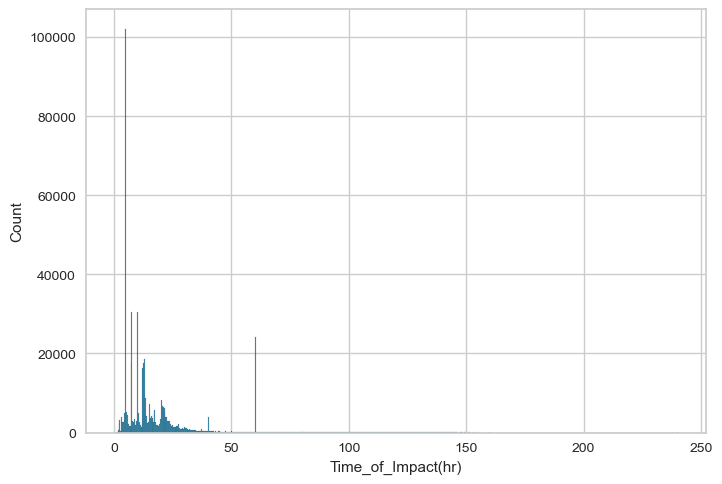

In [169]:
sns.histplot(data_clean['Time_of_Impact(hr)'])

## Saveout Data

In [72]:
if _LITE_SWITCH_:
    data_clean.to_csv('AccidentData_Sampled_Clean.csv')
else:
    data_clean.to_csv('AccidentData_Clean.csv')

In [ ]:
del data_clean
if _SPARK_:
    spark.stop()
else:
    pass

# 4-Full EDA

In [ ]:
if _SPARK_:
    spark = SparkSession.builder.appName("Accident Data Project").getOrCreate()
    data = spark.read.csv('AccidentData_Clean.csv',header=True,inferSchema=True)
else:
    if _LITE_SWITCH_:
        data = pd.read_csv('AccidentData_Sampled_Clean.csv')
    else:
        data = pd.read_csv('US_Accidents_March23.csv')
    

## Nature of Incident Variables

In [73]:
data.groupby('Severity')[['Distance(mi)','Time_of_Impact(hr)']].describe().T

Severity                        1          2         3         4
Distance(mi)       count 4274.000 398142.000 84520.000 13064.000
                   mean     0.112      0.569     0.423     1.484
                   std      0.703      1.608     2.118     3.392
                   min      0.000      0.000     0.000     0.000
                   25%      0.000      0.000     0.000     0.154
                   50%      0.000      0.067     0.000     0.487
                   75%      0.000      0.525     0.010     1.451
                   max     15.840    193.480   149.690   112.968
Time_of_Impact(hr) count 4274.000 398142.000 84520.000 13064.000
                   mean     7.660     19.245    11.411    31.685
                   std      4.696     21.679    13.710    28.493
                   min      2.500      0.000     0.069     0.000
                   25%      4.944      7.406     4.936     9.922
                   50%      7.461     12.914     7.400    21.236
                   75%      9.958     21.483    10.000    60.000
                   max     74.828    239.997   239.933   239.997

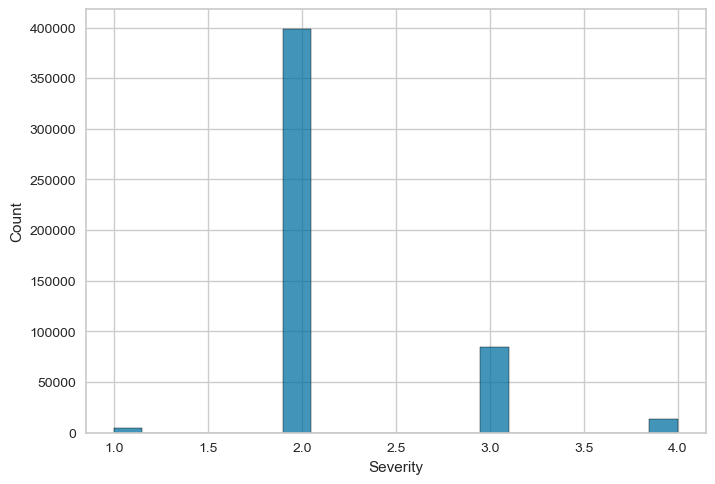

In [74]:
if _LITE_SWITCH_:
    sns.histplot(data['Severity'])
else:
    pass

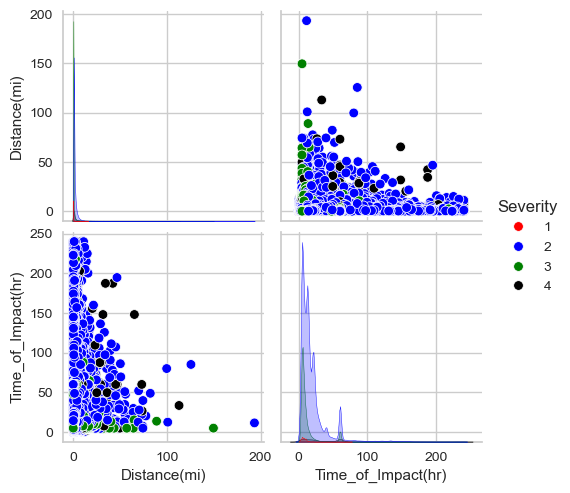

In [75]:
palette = {1:'red',2:'blue',3:'green',4:'black'}
sns.pairplot(data[['Severity','Distance(mi)','Time_of_Impact(hr)']],hue='Severity',palette=palette);

## Feature Variables

### Relationships

In [76]:
if _SPARK_:
    corr_data = data.select(_NUMERICS_)
    col_names = corr_data.columns
    features = corr_data.rdd.map(lambda row: row[0:]) 
    corrs = Statistics.corr(features, method="pearson")
else:
    corrs = data[_NUMERICS_].corr()
    print(corrs)
   

                   Distance(mi)  Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  Precipitation(in)
Distance(mi)              1.000          -0.057         -0.046        0.010        -0.099          -0.039            0.009             -0.001
Temperature(F)           -0.057           1.000          0.994       -0.331         0.108           0.213            0.033             -0.004
Wind_Chill(F)            -0.046           0.994          1.000       -0.314         0.086           0.230           -0.044             -0.012
Humidity(%)               0.010          -0.331         -0.314        1.000         0.119          -0.381           -0.171              0.083
Pressure(in)             -0.099           0.108          0.086        0.119         1.000           0.035           -0.024              0.017
Visibility(mi)           -0.039           0.213          0.230       -0.381         0.035           1.000            0.015             -0.130
Wind_S

<Axes: >

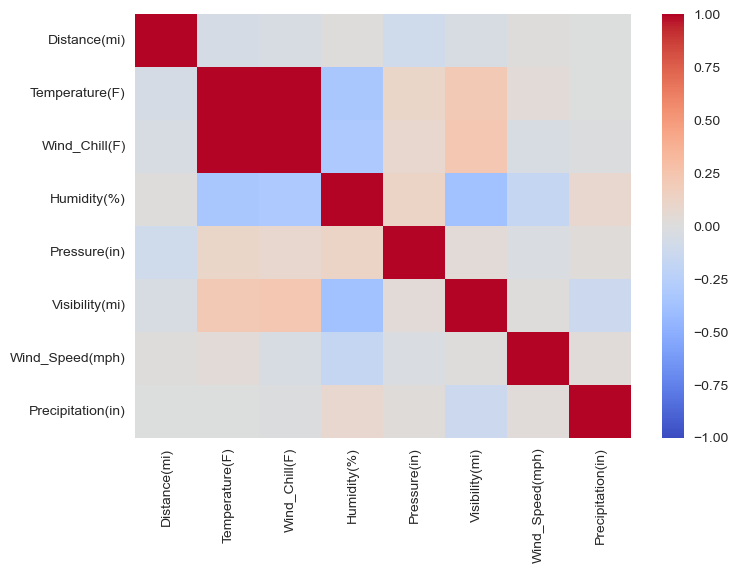

In [77]:
sns.heatmap(corrs,vmin=-1,vmax=1,cmap='coolwarm')

### Against Target Variable

### Infrastructure

### Weather Conditions

In [92]:
weather_descriptions = data.Weather_Condition.unique()
print(f'There are {weather_descriptions.shape[0]} ways that the weather is described in this dataset: \n')
print(weather_descriptions)

There are 109 ways that the weather is described in this dataset: 

['Fair' 'Wintry Mix' 'Light Rain' 'Cloudy' 'Mostly Cloudy' 'Partly Cloudy'
 'Clear' 'Scattered Clouds' 'Fog' 'Overcast' 'Light Snow' 'T-Storm' nan
 'Thunderstorms and Rain' 'Thunder' 'Light Rain with Thunder' 'Rain'
 'Showers in the Vicinity' 'Mostly Cloudy / Windy' 'Heavy Rain'
 'Cloudy / Windy' 'Light Drizzle' 'Heavy T-Storm' 'Light Rain / Windy'
 'Smoke' 'Haze' 'Blowing Dust / Windy' 'N/A Precipitation'
 'Thunder in the Vicinity' 'Snow' 'Heavy Thunderstorms and Rain'
 'Shallow Fog' 'Light Freezing Drizzle' 'Fair / Windy' 'Patches of Fog'
 'Light Snow / Windy' 'Blowing Snow / Windy' 'Thunderstorm' 'Drizzle'
 'T-Storm / Windy' 'Partly Cloudy / Windy' 'Heavy Rain / Windy'
 'Heavy Snow / Windy' 'Mist' 'Light Thunderstorms and Rain' 'Rain / Windy'
 'Light Freezing Rain' 'Heavy Snow' 'Light Ice Pellets'
 'Heavy T-Storm / Windy' 'Heavy Drizzle' 'Sleet' 'Light Rain Shower'
 'Haze / Windy' 'Snow and Sleet' 'Snow / Windy' 'Fo

In [97]:
description_counts = data.Weather_Condition.value_counts(dropna=False,normalize=True)
description_counts.sort_values(ascending=False)

Weather_Condition
Fair                 0.332
Mostly Cloudy        0.131
Cloudy               0.106
Clear                0.105
Partly Cloudy        0.090
                      ... 
Mist / Windy         0.000
Light Blowing Snow   0.000
Low Drifting Snow    0.000
Light Haze           0.000
Sand                 0.000
Name: proportion, Length: 109, dtype: float64

In [101]:
weather_factors = ['Temperature(F)','Wind_Chill(F)','Humidity(%)',
                   'Pressure(in)','Visibility(mi)',
                   'Wind_Speed(mph)','Precipitation(in)']

In [ ]:
X = data[weather_factors].dropna()
scaler = StandardScaler() 
X_std =scaler.fit_transform(X)

In [80]:
pca = PCA()
pca.fit(X_std);

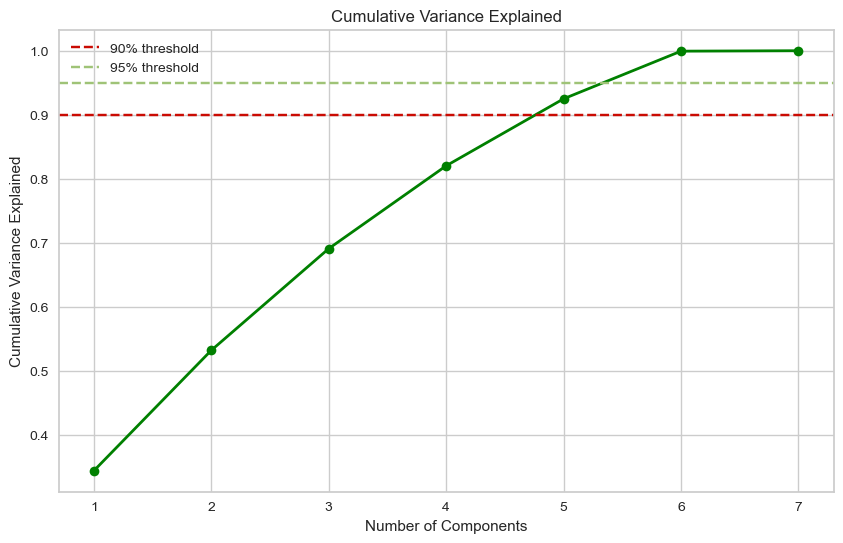

In [81]:
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
# Create a cumulative variance plot
plt.figure(figsize=(10, 6))
cum_var_plot = plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 
         'o-', linewidth=2, color='green')
# Add lines for 90% and 95% thresholds
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
target_variance = 0.95
n_components_variance = np.argmax(cumulative_var >= target_variance) + 1
print(f'We choose to include the first {n_components_variance} components.')

We choose to include the first 6 components.


In [83]:
pca = PCA(n_components=n_components_variance)
pca.fit(X_std);
# Transform the standardized data to get principal components
X_pca = pca.transform(X_std)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(
    data=X_pca,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]
)
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6
0,1.171,0.564,-0.472,-0.048,0.035,0.016
1,-0.512,-0.601,-0.657,0.295,0.846,-0.802
2,0.525,0.080,0.367,0.929,-0.146,0.672
3,-2.515,-1.605,0.500,0.901,0.356,1.029
4,-0.454,-0.746,-1.140,-0.384,1.134,-1.473
...,...,...,...,...,...,...
339507,-1.422,-0.812,0.511,1.332,0.500,0.611
339508,0.859,0.786,0.446,0.885,-0.312,1.203
339509,0.211,-3.726,1.884,-2.208,-0.326,-0.287
339510,1.859,-0.793,1.145,0.126,-0.402,-0.003


In [84]:
# Create an easy to view DF of the loadings.
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components_variance)],
    index=weather_factors
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
Temperature(F),0.592,0.261,0.105,-0.100,-0.219,0.110
Wind_Chill(F),0.590,0.280,0.066,-0.132,-0.203,0.109
Humidity(%),-0.392,0.457,-0.150,0.044,-0.204,0.756
Pressure(in),0.095,0.503,-0.313,0.703,0.248,-0.291
Visibility(mi),0.354,-0.368,-0.294,0.077,0.622,0.510
Wind_Speed(mph),0.054,-0.277,0.651,0.640,-0.166,0.243
Precipitation(in),-0.103,0.423,0.595,-0.249,0.628,-0.007


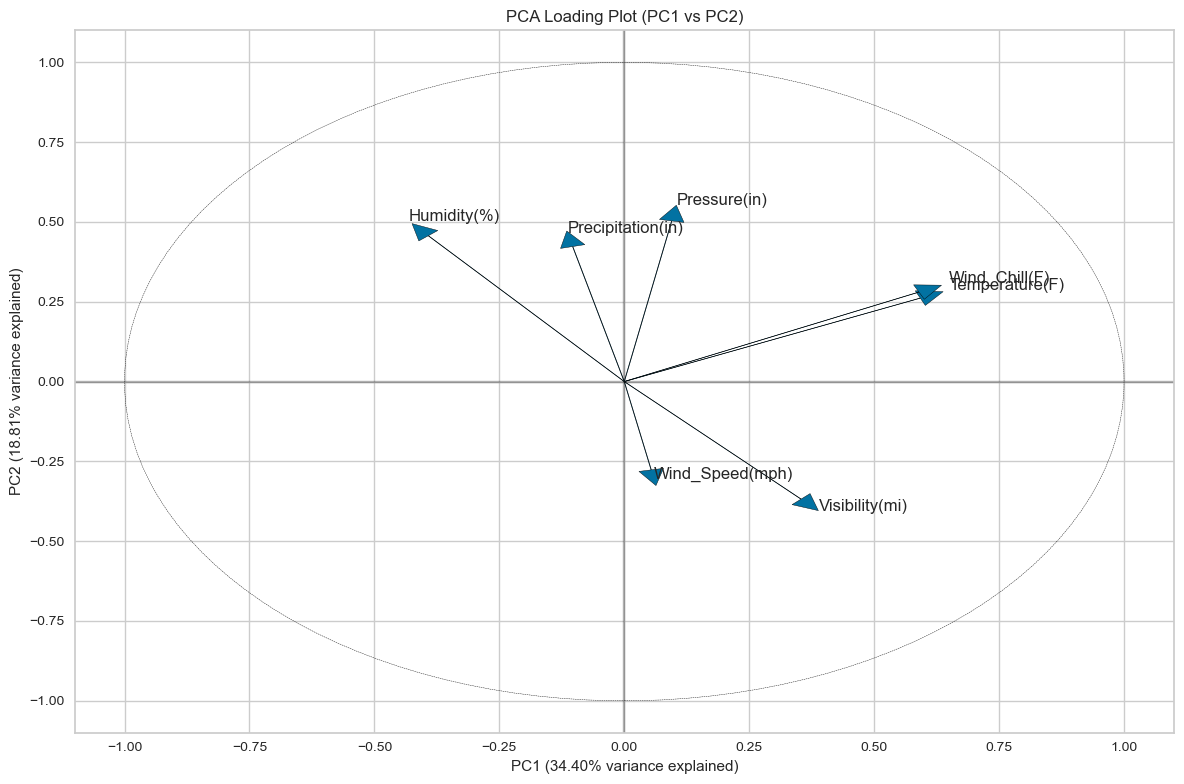

In [85]:
# Visualize the loadings for the first two PCs
plt.figure(figsize=(12, 8))
for i, feature in enumerate(weather_factors):
    plt.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], head_width=0.05, head_length=0.05)
    plt.text(loadings.iloc[i, 0]*1.1, loadings.iloc[i, 1]*1.1, feature, fontsize=12)

# Add a unit circle for reference
circle = plt.Circle((0, 0), 1, fill=False, linestyle='--')
plt.gca().add_patch(circle)

plt.grid(True)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.title('PCA Loading Plot (PC1 vs PC2)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')
plt.tight_layout()
plt.show()

In [117]:
X = data[weather_factors+['Weather_Condition']].dropna()[weather_factors]
scaler = StandardScaler() 
X_std =scaler.fit_transform(X)

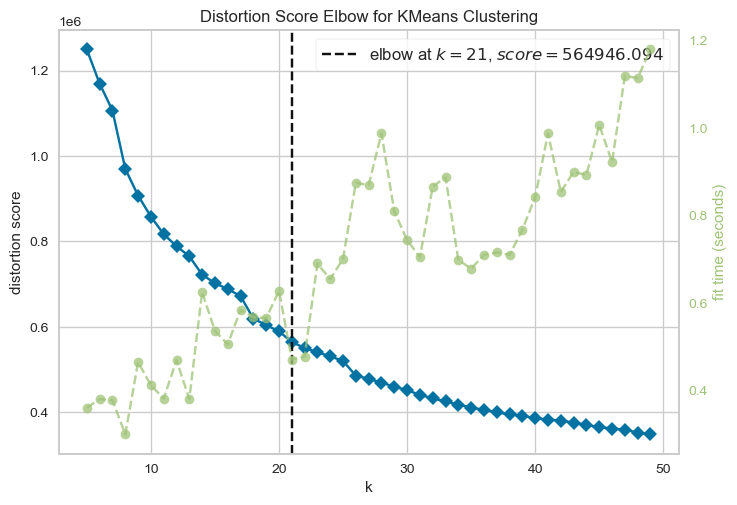

In [118]:
# Write your code here
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km,k=(5,50))
visualizer.fit(X_std)
visualizer.show();

Recall, the heavily-skewed distribution of weather descripitions.  

In [120]:
km = KMeans(random_state=42,n_clusters=21)
km.fit(X_std)
pd.DataFrame(scaler.inverse_transform(km.cluster_centers_),columns=weather_factors)

,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
0,74.300,74.300,81.690,29.707,9.710,7.030,0.003
1,35.503,31.239,66.921,25.267,9.819,6.683,0.001
2,28.494,19.951,88.652,29.323,2.340,10.774,0.013
3,79.413,79.413,61.204,29.718,9.872,15.081,0.001
4,41.264,40.212,83.533,29.647,9.575,2.305,0.002
5,88.805,88.805,27.334,29.211,9.827,8.534,0.000
6,57.621,57.256,76.895,29.631,9.745,8.397,0.002
7,71.052,71.010,91.454,29.651,3.206,10.445,1.372
8,66.645,66.645,36.509,29.538,9.855,3.845,0.000
9,42.561,35.645,63.640,29.377,9.694,17.247,0.003


In [133]:
pd.Series(km.labels_).value_counts(normalize=True).sort_values(ascending=False)

14   0.106
0    0.091
6    0.090
16   0.086
4    0.077
8    0.071
3    0.070
20   0.065
15   0.057
5    0.053
17   0.051
18   0.040
2    0.035
9    0.035
10   0.025
1    0.022
19   0.014
13   0.006
11   0.003
12   0.001
7    0.000
Name: proportion, dtype: float64

In [ ]:
described_obsv = pd.DataFrame(data[weather_factors+['Weather_Condition']].dropna()['Weather_Condition'])
described_obsv['Cluster'] = km.labels_
described_obsv

In [139]:
cluster_v_descr = pd.crosstab(described_obsv['Cluster'],described_obsv['Weather_Condition'])
cluster_v_descr

Weather_Condition,Blowing Dust,Blowing Dust / Windy,Blowing Snow,Blowing Snow / Windy,Clear,Cloudy,Cloudy / Windy,Drifting Snow / Windy,Drizzle,Drizzle / Windy,Drizzle and Fog,Fair,Fair / Windy,Fog,Fog / Windy,Freezing Drizzle,Freezing Rain,Funnel Cloud,Hail,Haze,Haze / Windy,Heavy Drizzle,Heavy Rain,Heavy Rain / Windy,Heavy Sleet,Heavy Snow,Heavy Snow / Windy,Heavy T-Storm,Heavy T-Storm / Windy,Heavy Thunderstorms and Rain,Ice Pellets,Light Blowing Snow,Light Drizzle,Light Drizzle / Windy,Light Freezing Drizzle,Light Freezing Fog,Light Freezing Rain,Light Freezing Rain / Windy,Light Ice Pellets,Light Rain,Light Rain / Windy,Light Rain Shower,Light Rain Shower / Windy,Light Rain Showers,Light Rain with Thunder,Light Sleet,Light Snow,Light Snow / Windy,Light Snow Grains,Light Snow Shower,Light Snow and Sleet,Light Snow and Sleet / Windy,Light Snow with Thunder,Light Thunderstorms and Rain,Light Thunderstorms and Snow,Mist,Mostly Cloudy,Mostly Cloudy / Windy,N/A Precipitation,Overcast,Partial Fog,Partial Fog / Windy,Partly Cloudy,Partly Cloudy / Windy,Patches of Fog,Rain,Rain / Windy,Sand / Dust Whirlwinds,Scattered Clouds,Shallow Fog,Showers in the Vicinity,Sleet,Sleet / Windy,Small Hail,Smoke,Smoke / Windy,Snow,Snow / Windy,Snow and Sleet,Snow and Sleet / Windy,Snow and Thunder,Squalls / Windy,T-Storm,T-Storm / Windy,Thunder,Thunder / Windy,Thunder / Wintry Mix,Thunder and Hail,Thunder in the Vicinity,Thunderstorms and Rain,Tornado,Widespread Dust / Windy,Wintry Mix,Wintry Mix / Windy
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,6538,0,0,17,0,0,11444,0,0,0,0,0,0,0,144,0,0,14,0,0,0,0,20,0,0,0,0,77,0,0,0,0,0,0,2060,0,2,0,0,201,0,0,0,0,0,0,0,0,0,0,1,6386,0,0,0,0,0,3083,0,8,142,0,0,0,9,17,0,0,0,12,0,0,0,0,0,0,0,231,0,227,0,0,0,272,0,0,0,0,0
1,0,1,0,0,0,1672,52,0,1,0,0,3261,61,0,0,0,1,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,17,1,1,0,2,0,0,280,10,4,0,0,3,0,148,6,0,0,0,0,0,0,0,2,1051,23,13,0,0,1,768,22,6,19,0,0,0,0,2,0,0,0,5,0,0,0,0,0,0,0,4,0,2,0,0,0,4,0,0,0,34,0
2,0,0,17,47,1,997,35,0,21,0,8,190,5,781,39,1,8,0,0,183,68,0,67,9,2,185,41,6,2,1,5,0,217,6,55,6,99,2,7,1315,58,1,0,3,7,18,5067,272,1,0,5,2,1,1,1,3,72,3,87,177,0,0,33,0,1,388,32,0,1,1,0,6,1,5,0,0,680,53,28,3,0,0,23,3,0,0,3,0,0,2,0,0,527,11
3,0,0,0,0,0,2469,240,0,0,0,0,8014,559,1,0,0,0,1,0,50,8,0,7,6,0,0,0,13,18,0,0,0,17,4,0,0,0,0,0,489,118,0,0,0,131,0,0,0,0,0,0,0,0,0,0,0,6050,453,0,0,0,0,4228,238,0,36,16,0,0,1,12,0,0,0,27,0,0,0,0,0,0,0,66,32,262,35,0,0,279,0,0,0,0,0
4,0,0,0,0,4,5710,0,0,35,0,0,14445,0,1,0,0,1,0,0,141,0,0,2,0,0,0,0,0,0,0,0,0,79,0,6,0,16,0,0,1630,0,0,0,0,1,1,112,0,0,0,0,0,0,0,0,7,2172,0,8,212,0,0,1339,0,59,119,0,0,9,50,5,0,0,0,5,0,0,0,0,0,0,0,4,0,0,0,0,0,4,0,0,0,49,0
5,2,0,0,0,0,140,0,0,0,0,0,13665,29,0,0,0,0,0,0,223,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,16,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1449,1,0,0,0,0,2258,4,0,1,0,5,0,0,1,0,0,0,168,2,0,0,0,0,0,0,1,0,19,0,0,0,26,0,0,0,0,0
6,0,0,0,0,0,9990,0,0,19,0,0,10445,0,0,0,0,0,0,0,85,0,1,18,0,0,1,0,2,0,0,0,0,116,0,0,0,0,0,0,2644,0,2,0,0,22,0,1,0,0,0,0,0,0,1,0,0,4669,0,0,46,0,0,2195,0,6,176,0,0,1,7,5,0,0,0,26,0,0,0,0,0,0,0,41,0,14,0,0,0,24,0,0,0,0,0
7,0,0,0,0,0,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,48,4,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,4,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,1,2,0,0,0,0,0,0,0,0,0
8,4,0,0,0,0,1056,0,0,0,0,0,18908,0,0,0,0,0,0,0,235,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,42,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2018,0,0,0,0,0,1725,0,0,1,0,0,0,0,0,0,0,0,67,0,0,0,0,0,0,0,0,0,1,0,0,0,7,0,0,0,0,0


# 5-Statistical Analysis
Chi-Squared and ANOVA Tests for various features 

## Severity as An Input Feature for Distance and Time of Impact

In [ ]:
model_weather = ols("Q('Distance(mi)') ~ C(Severity)", data=data).fit()
anova_table_weather = sm.stats.anova_lm(model_weather, typ=2)
print("\nANOVA for Weather Category:\n", anova_table_weather)
p_weather = anova_table_weather['PR(>F)'].iloc[0]
print(f"P-value for Weather Category: {p_weather}")

In [ ]:
model_weather = ols("Q('Time_of_Impact(hr)') ~ C(Severity)", data=data).fit()
anova_table_weather = sm.stats.anova_lm(model_weather, typ=2)
print("\nANOVA for Weather Category:\n", anova_table_weather)
p_weather = anova_table_weather['PR(>F)'].iloc[0]
print(f"P-value for Weather Category: {p_weather}")

## Weather Category
* Null Hypothesis (H0): There is no significant difference in accident severity across weather categories.

* Alternative Hypothesis (H1): There is a significant difference in accident severity across weather categories.

In [156]:
def test_results(feature_name,dataset,alpha=0.975):
    anova_time,anova_distance,chi_test= test_category(feature_name,dataset)
    p_vals = dict()
    p_vals['time'] = ('ANOVA',anova_time['PR(>F)'].iloc[0])
    p_vals['distance'] = ('ANOVA', anova_distance['PR(>F)'].iloc[0])
    p_vals['severity'] = ('CHI-Squared', chi_test[1])

    test_results = []
    for topic, p_val in p_vals.items():
        msg = f"Based on the {p_val[0]} test's p-value of {p_val[1]}, "
        null_hypo = f"the null hypothesis that there is no significant difference in incident {topic}"
        null_hypo += f" across different {feature_name}s."
        if (1 - alpha) > p_val[1]:
            msg += f"we reject " + null_hypo
        else:
            msg += f"we fail to reject " + null_hypo
        print(msg)
        test_results.append(msg)
    return test_results, [anova_time,anova_distance,chi_test]

def test_category(feature_name,dataset):
    # Time of Impact--ANOVA
    model_time = ols(f"Q('Time_of_Impact(hr)') ~ C({feature_name})", data=dataset).fit()
    anova_table_time = sm.stats.anova_lm(model_time, typ=2)
    # Distance of Impact--ANOVA
    model_distance = ols(f"Q('Distance(mi)') ~ C({feature_name})", data=dataset).fit()
    anova_table_distance = sm.stats.anova_lm(model_distance, typ=2)
    # Severity Distribution--ANOVA
    contingency_table = pd.crosstab(dataset[feature_name], dataset['Severity'])
    chi_results = chi2_contingency(contingency_table)
    return anova_table_time, anova_table_distance, chi_results


## YoY Difference?

In [143]:
reports,stats = test_results('Year',data)

Based on the ANOVA test's p-value of 0.0 , we reject the null hypothesis that there is no significant difference in incident time across the different values for Year.
Based on the ANOVA test's p-value of 0.0 , we reject the null hypothesis that there is no significant difference in incident distance across the different values for Year.
Based on the CHI-Squared test's p-value of 0.0 , we reject the null hypothesis that there is no significant difference in incident severity across the different values for Year.


In [145]:
data.groupby('Year')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

,Severity,Time_of_Impact(hr),Distance(mi)
Year,,,
2016,2.373,23.600,0.236
2017,2.391,19.019,0.274
2018,2.383,11.642,0.285
2019,2.310,12.394,0.299
2020,2.188,20.049,0.454
2021,2.133,21.915,0.704
2022,2.072,18.057,0.938
2023,2.060,19.827,0.973


## Quarterly Difference?

In [146]:
reports,stats = test_results('Quarter',data)

Based on the ANOVA test's p-value of 1.4131568494615394e-179 , we reject the null hypothesis that there is no significant difference in incident time across the different values for Quarter.
Based on the ANOVA test's p-value of 3.9367012183066435e-25 , we reject the null hypothesis that there is no significant difference in incident distance across the different values for Quarter.
Based on the CHI-Squared test's p-value of 0.0 , we reject the null hypothesis that there is no significant difference in incident severity across the different values for Quarter.


In [147]:
data.groupby('Year')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

,Severity,Time_of_Impact(hr),Distance(mi)
Year,,,
2016,2.373,23.600,0.236
2017,2.391,19.019,0.274
2018,2.383,11.642,0.285
2019,2.310,12.394,0.299
2020,2.188,20.049,0.454
2021,2.133,21.915,0.704
2022,2.072,18.057,0.938
2023,2.060,19.827,0.973


## Time of Day?

In [159]:
reports,stats = test_results('Hour',data)
data.groupby('Hour')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 0.0, we reject the null hypothesis that there is no significant difference in incident time across different Hours.
Based on the ANOVA test's p-value of 3.344793671776e-270, we reject the null hypothesis that there is no significant difference in incident distance across different Hours.
Based on the CHI-Squared test's p-value of 0.0, we reject the null hypothesis that there is no significant difference in incident severity across different Hours.


,Severity,Time_of_Impact(hr),Distance(mi)
Hour,,,
0,2.218,23.534,0.679
1,2.182,22.109,0.615
2,2.206,22.588,0.621
3,2.223,25.820,0.701
4,2.235,22.136,0.600
5,2.220,24.516,0.687
6,2.207,18.761,0.635
7,2.188,14.997,0.490
8,2.189,14.361,0.379


In [160]:
reports,stats = test_results('Evening_Rush',data)
data.groupby('Evening_Rush')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 2.8906720313594234e-172, we reject the null hypothesis that there is no significant difference in incident time across different Evening_Rushs.
Based on the ANOVA test's p-value of 3.397614143966434e-15, we reject the null hypothesis that there is no significant difference in incident distance across different Evening_Rushs.
Based on the CHI-Squared test's p-value of 5.612349293973288e-42, we reject the null hypothesis that there is no significant difference in incident severity across different Evening_Rushs.


,Severity,Time_of_Impact(hr),Distance(mi)
Evening_Rush,,,
False,2.213,18.618,0.576
True,2.211,16.678,0.529


In [161]:
reports,stats = test_results('Morning_Rush',data)
data.groupby('Morning_Rush')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 0.0, we reject the null hypothesis that there is no significant difference in incident time across different Morning_Rushs.
Based on the ANOVA test's p-value of 9.956900061782129e-50, we reject the null hypothesis that there is no significant difference in incident distance across different Morning_Rushs.
Based on the CHI-Squared test's p-value of 1.0203266569605868e-135, we reject the null hypothesis that there is no significant difference in incident severity across different Morning_Rushs.


,Severity,Time_of_Impact(hr),Distance(mi)
Morning_Rush,,,
False,2.217,18.798,0.585
True,2.199,15.993,0.497


In [162]:
reports,stats = test_results('Sunrise_Sunset',data)
data.groupby('Sunrise_Sunset')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 8.598230755843086e-271, we reject the null hypothesis that there is no significant difference in incident time across different Sunrise_Sunsets.
Based on the ANOVA test's p-value of 1.782589288872599e-24, we reject the null hypothesis that there is no significant difference in incident distance across different Sunrise_Sunsets.
Based on the CHI-Squared test's p-value of 5.423533369073328e-271, we reject the null hypothesis that there is no significant difference in incident severity across different Sunrise_Sunsets.


,Severity,Time_of_Impact(hr),Distance(mi)
Sunrise_Sunset,,,
Day,2.210,17.439,0.545
Night,2.219,19.704,0.600


# Day of Week, Weekend/Workday & Holiday

In [157]:
reports,stats = test_results('DayofWeek',data)
data.groupby('DayofWeek')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 7.516693114188178e-84, we reject the null hypothesis that there is no significant difference in incident time across different DayofWeeks.
Based on the ANOVA test's p-value of 5.063693952185596e-52, we reject the null hypothesis that there is no significant difference in incident distance across different DayofWeeks.
Based on the CHI-Squared test's p-value of 1.395250051546697e-125, we reject the null hypothesis that there is no significant difference in incident severity across different DayofWeeks.


,Severity,Time_of_Impact(hr),Distance(mi)
DayofWeek,,,
0,2.212,17.565,0.527
1,2.206,17.784,0.539
2,2.204,17.734,0.544
3,2.204,18.003,0.556
4,2.207,18.501,0.572
5,2.239,19.569,0.634
6,2.254,18.982,0.667


In [158]:
reports,stats = test_results('Weekend',data)
data.groupby('Weekend')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 0.013217778331793181, we reject the null hypothesis that there is no significant difference in incident time across different Weekends.
Based on the ANOVA test's p-value of 0.12717058603954887, we fail to reject the null hypothesis that there is no significant difference in incident distance across different Weekends.
Based on the CHI-Squared test's p-value of 9.45620552517738e-23, we reject the null hypothesis that there is no significant difference in incident severity across different Weekends.


,Severity,Time_of_Impact(hr),Distance(mi)
Weekend,,,
False,2.209,18.187,0.562
True,2.225,18.012,0.571


In [ ]:
reports,stats = test_results('Holiday',data)
data.groupby('Holiday')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 0.008287021437518081 , we reject the null hypothesis that there is no significant difference in incident time across the different values for Holiday.
Based on the ANOVA test's p-value of 0.29684653058608623 , we fail to reject the null hypothesis that there is no significant difference in incident distance across the different values for Holiday.
Based on the CHI-Squared test's p-value of 0.1223786874089896 , we fail to reject the null hypothesis that there is no significant difference in incident severity across the different values for Holiday.


## By State

In [163]:
reports,stats = test_results('State',data)
data.groupby('State')[['Severity','Time_of_Impact(hr)','Distance(mi)']].mean()

Based on the ANOVA test's p-value of 0.0, we reject the null hypothesis that there is no significant difference in incident time across different States.
Based on the ANOVA test's p-value of 0.0, we reject the null hypothesis that there is no significant difference in incident distance across different States.
Based on the CHI-Squared test's p-value of 0.0, we reject the null hypothesis that there is no significant difference in incident severity across different States.


,Severity,Time_of_Impact(hr),Distance(mi)
State,,,
AL,2.243,14.476,0.459
AR,2.286,17.435,1.421
AZ,2.122,16.826,0.564
CA,2.166,18.596,0.493
CO,2.435,15.291,0.903
CT,2.360,21.595,1.120
DC,2.114,20.047,0.365
DE,2.275,15.094,0.468
FL,2.139,21.751,0.527


## Advanced Analysis

# 6-Insights & Conclusions

## Annual Distinctions

Number of Accidents; Distribution of Severities; Length of Impact

## Temporal & Spatial Considerations

How do accident counts relate to different times of the day and for different region types (urban vs rural)?

## Weather Considerations
Does certain weather conditions produce more severe incidents?  

## Severity Prediction

## Unusual Weather 

Does driving in unexpected weather--based on area, time of year and/or both--create a higher likelihood of an accident.

## Famous Highways

## Highway's Near Urban Areas

For cross-state

## Naturual Language

Examination of the description feature.

## Safety Infrastructure
Does certain road infrastructure projects help reduce the number of incidents?

## New Traffic Pattern

Does the existence of a new traffic pattern in the area increase the likelihood of an accident?

## Recent Accident Indicator

Does the presence of one accident, predict another.